# Chapter 4: The Bias-Variance Trade-off

#### From Stephen Klosterman's book DATA SCIENCE PROJECTS WITH PYTHON (2019).

<h3>Goals:</h3>
<ul>
    <li>Describe the log-loss cost function of logistic regression</li>
    <li>Implement the gradient descent procedure for estimating model parameters</li>
    <li>Articulate the formal statistical assumptions of the logistic regression model.</li>
    <li>Characterize the bias-variance trade-off and use it to improve models</li>
    <li>Formulate lasso and ridge regularization and use them in scikit-learn</li>
    <li>Design a function to choose regularization</li>
    <li>Engineer interaction features to improve an underfit model</li>
</ul>

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn

In [2]:
import matplotlib as mpl

import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline

import seaborn as sns #a fancy plotting package
mpl.rcParams['figure.dpi'] = 50 

# Estimating the Coefficients and Intercepts of Logistic Regression

<p>The coefficients of logistic regression (each of which goes with a particular feature), and the intercept, are determined when the <code>.fit</code> method is called on a logistic regression model in scikit-learn using the training data. These numbers are called <strong>parameters</strong> of the model, and the process of finding the best values for them is called parameter <strong>estimation</strong>.</p>

<h3>Cost Function</h3>
<p>A cost function is a way of telling how far away the model predictions are from perfectly describing model; that is, the larger errors between the model predictions and the actual data.</p>

### Log-loss Function
#### For classification problems, especially in fitting logistic regression models, a typical cost function is the log-loss function, also called entropy loss.

In [3]:
X_log = np.linspace(0.01,0.99,99)
print(X_log[:5], '...', X_log[-5:])

[0.01 0.02 0.03 0.04 0.05] ... [0.95 0.96 0.97 0.98 0.99]


In [4]:
y_log = np.log(X_log)

Text(0.5, 1.0, 'Natural logarithm')

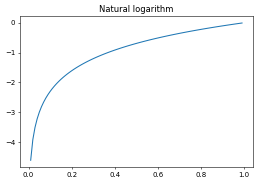

In [5]:
plt.plot(X_log, y_log)
plt.title('Natural logarithm')

# Gradient Descent to Find Optimal Parameter Values

<p>The process of <strong>optimization</strong> is that of finding a set of parameters that incurs in the <strong>minimum</strong> cost. This process is done automatically by the <code>.fit</code> method. You can choose different techniques with the <strong>solver</strong> keyword.</p>

<p>All of these techniques work a little differently, but they are all based on the concept of <strong>gradient descent</strong>.</p>

## Exercise 16: Using Gradient Descent to Minimize a Cost Function

In [6]:
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


In [7]:
def cost_function(X):
    return X * (X-2)

In [8]:
y_poly = cost_function(X_poly)

Text(0.5, 1.0, 'Error surface')

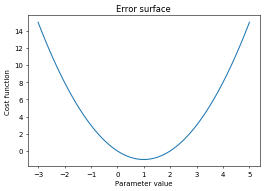

In [9]:
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.title('Error surface')

<p>Above, we can see that the value thatwill result in the lowest value of the cost function is <em>x = 1</em>.</p>

<p><strong>Gradient descent</strong> is an iterative algorithm; starting from the initial guess, we try to find a new guess that lowers the cost function and continue with this until we've found a good solution.</p>

<p>In mathematical terms, we only know the value of the <strong>derivative</strong> at the parameter of the current guess, which tells you which direction is downhill, and how steep the hill is from where you're standing.</p>

<p>How big a step we decide to take, depends on the <strong>learning rate</strong>. Since the gradient declines toward the direction of decreasing error, we want to take a step in the direction that is the negative of the gradient.</p>

<p>Although gradient descent works in higher-dimensional spaces, you can only visualize up to a two-dimensional error surface on a single graph.</p>

In [10]:
def gradient(X):
    return (2*X) - 2

In [11]:
x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start)*learning_rate
x_next

-0.75

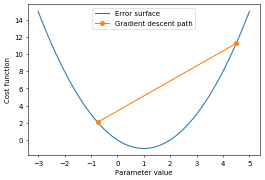

In [12]:
plt.plot(X_poly, y_poly)
plt.plot([x_start, x_next], [cost_function(x_start), cost_function(x_next)], '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

<p>Above, it appears as though we've taken a step in the right direciton. However, it's clear that we've "overshot" where we want to be. It may be that our learning rate is too large, and consequently, we are taking steps that are too big.</p>

<p>While tuning the learning rate will be a good idea to converge toward an optimal solution more quickly, in this example we can just continue illustrating the remainder of the process.</p>

<p>In practice, gradient descent continues until the size of the steps becomes very small, or the change in the cost function becomes very small (you can specify how small by using the <strong>tol</strong> argument in the scikit-learn logistic regression), indicating that we're "close enough" to a good solution (a <strong>local minimum</strong>).</p>

#### Perform 14 iterations to converge toward the local minimum of the cost function

In [13]:
iterations = 15
x_path = np.empty(iterations,)
x_path[0] = x_start
for iteration_count in range(1,iterations):
    derivative = gradient(x_path[iteration_count-1])
    x_path[iteration_count] = x_path[iteration_count-1] - (derivative*learning_rate)
    
x_path

array([ 4.5       , -0.75      ,  1.875     ,  0.5625    ,  1.21875   ,
        0.890625  ,  1.0546875 ,  0.97265625,  1.01367188,  0.99316406,
        1.00341797,  0.99829102,  1.00085449,  0.99957275,  1.00021362])

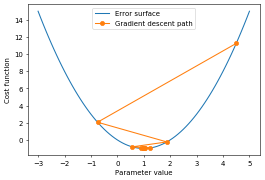

In [14]:
plt.plot(X_poly, y_poly)
plt.plot(x_path, cost_function(x_path), '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

## Assumptions of Logistic Regression

<p>While it's not necessary to follow every one of these assumptions in the strictest possible sense, it's good to be aware of them.</p>

### Features are Linear in the Log Odds
<p>Logistic regression won't capture interactions, polynomial features, or the discretization of features, not on its own.</p>
<p>You can, however, specify all of these as "new features", even though they are engineered from already existing features.</p>

### No Multicollinearity of Features

<p>Features are assumed to be correlated with each other.</p>

In [15]:
df = pd.read_csv('Data/Chapter_1_cleaned_data_OLD.csv')

features_response = df.columns.tolist()

items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

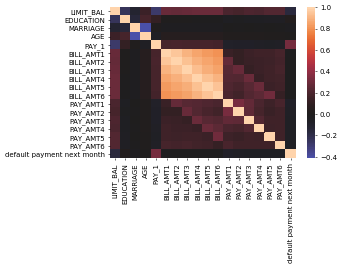

In [16]:
corr = df[features_response].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

### Observations (samples) are assume to be independent

<p>Across different domains of data, some common violations of independence of observations are as follows:</p>
<ul>
    <li><strong>Spatial autocorrelation</strong> of observations; for example, in natural phenomena such as soil types, where observations that are geographically closer to each other may be similar to each other.</li>
    <li><strong>Temporal autocorrelation</strong> of observations, which may occur in a time series data. Observations at the current point in time are usually assumed to be correlated to the most recent point(s) in time.</li>
    </ul>

### No Outliers

Text(0.5, 1.0, 'Synthetic linear data and line of best fit')

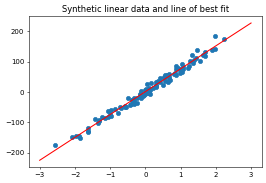

In [17]:
from sklearn.datasets import make_regression
from scipy.stats import linregress

X_syn_lin, y_syn_lin = make_regression(n_samples=100, n_features=1, n_informative=1,
                       n_targets=1, bias=0.0, effective_rank=None,
                       tail_strength=0.5, noise=10.0, shuffle=True,
                       coef=False, random_state=24)

m, b, r, p, std = linregress(X_syn_lin.reshape(len(X_syn_lin),), y_syn_lin)

x_regression = np.array([-3, 3])
y_regression = m*x_regression + b

plt.scatter(X_syn_lin, y_syn_lin)
plt.plot(x_regression, y_regression, 'r-')
plt.title('Synthetic linear data and line of best fit')

Text(0.5, 1.0, 'Synthetic linear data with outlier and line of best fit')

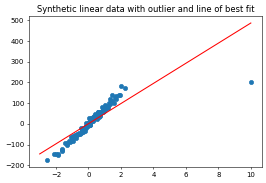

In [18]:
X_syn_lin = np.append(X_syn_lin, 10)
y_syn_lin = np.append(y_syn_lin, 200)

m, b, r, p, std = linregress(X_syn_lin.reshape(len(X_syn_lin),), y_syn_lin)

x_regression = np.array([-3, 10])
y_regression = m*x_regression + b

plt.scatter(X_syn_lin, y_syn_lin)
plt.plot(x_regression, y_regression, 'r-')
plt.title('Synthetic linear data with outlier and line of best fit')

### How many features should you include>

#### A common rule of thumg is the RULE OF 10: for every 10 occurrences of the rarest outcome class, 1 feature may be added to the model.

#### In a binary logistic regression problem with 100 samples, if the class balance 20% positive outcomes and 80% negative outcomes, then there are only 20 positive outcomes in total, and so only 2 features should be used in the model.

# The Motivation for Regularization: the Bias-Variance Trade-off
Generate quadratic data with random noise to illustrate this.

<p>In some cases, it may be desirable to introduce some bias into the model training process, especially if this decreases overfitting and increases the performance of new, unseen data. In this way, it may be possible to leverage the bias-variance trade-off to improve a model. We can use <strong>regularization</strong> methods to accomplish this. Additionally, we may also be able to use these methods for <strong>variable selection</strong> as part of the modeling process. Using a predictive model to select variables is an alternative to the uivariate feature selection methods that we have explored already.</p>

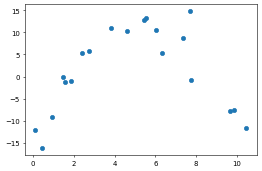

In [19]:
np.random.seed(seed=9)
n_points = 20
X = np.random.uniform(0, 11, n_points)
X = np.sort(X)
Y = (-X+2) * (X-9) + np.random.normal(0, 3, n_points)
plt.scatter(X, Y)

In [20]:
lin_fit = np.polyfit(X, Y, 1)

#### Function to take in the polynomial coefficients and produce the y values

In [21]:
def poly_fun(X, p):
    Y = np.zeros_like(X)
    power = len(p)-1
    for coefficient in p:
        Y = Y + coefficient*X**power
        power = power - 1
    return Y

poly_fun(X,lin_fit)

array([-0.56795261, -0.42917123, -0.2075489 ,  0.03588094,  0.07638692,
        0.19702737,  0.45030033,  0.59479584,  1.07117738,  1.42827491,
        1.80618691,  1.83602902,  2.06083994,  2.18273629,  2.64318106,
        2.8007159 ,  2.81695454,  3.67843349,  3.77355591,  4.03257388])

#### Plot the models over a more continuous range of values

(-20, 20)

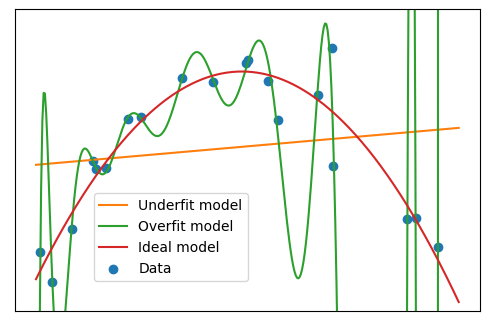

In [22]:
mpl.rcParams['figure.dpi'] = 100 #high res figures

curve_x = np.linspace(0,11,333)

cmap = mpl.cm.get_cmap('tab10')

plt.scatter(X, Y, label='Data', color=cmap(0))
plt.plot(curve_x, poly_fun(curve_x,lin_fit), label='Underfit model', color=cmap(1))
plt.plot(curve_x, poly_fun(curve_x,np.polyfit(X, Y, 15)), label='Overfit model', color=cmap(2))
plt.plot(curve_x, poly_fun(curve_x,np.polyfit(X, Y, 2)), label='Ideal model', color=cmap(3))
plt.legend(loc=[0.17, 0.1])
plt.xticks([])
plt.yticks([])
plt.ylim([-20, 20])

# Exercise 17: Generating and Modeling Synthetic Classification Data

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#### Generate a dataset with two variables, x_synthetic and y_syntehtic, 200 candidate features, and 1000 samples.

In [24]:
X_synthetic, y_synthetic = \
make_classification(n_samples=1000, n_features=200, n_informative=3, n_redundant=10,
                    n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None,
                    flip_y=0.01, class_sep=0.8, hypercube=True, shift=0.0, scale=1.0,
                    shuffle=True, random_state=24)

print(X_synthetic.shape, y_synthetic.shape)
print(np.mean(y_synthetic))

(1000, 200) (1000,)
0.501


#### Plot the first few features as histograms to show that the range of values is the same

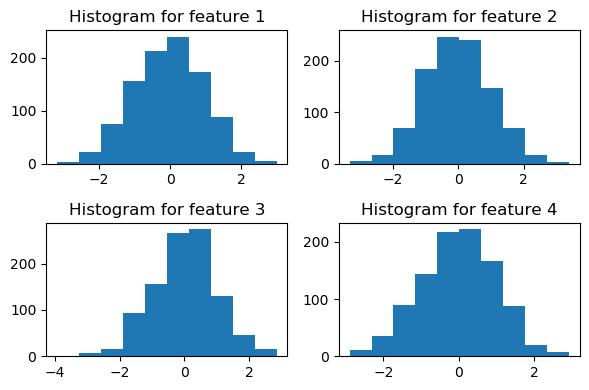

In [25]:
for plot_index in range(4):
    plt.subplot(2,2,plot_index+1)
    plt.hist(X_synthetic[:,plot_index])
    plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

<p>We have 500 observations in the rarest class, so by the rule of 10 we shouldn't have more than 50 features.</p>

#### Split the data into training and testing sets using an 80/20 split, and then instantiate a logistic regression model.

In [26]:
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
X_synthetic, y_synthetic,
test_size=0.2, random_state=24)

lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

<p>We specify the <strong>penalty</strong> argument to be <strong>l1</strong>. This means we are going to use <strong>L1 regularization</strong>, which is also known as <strong>lasso regularization</strong>.</p>

<p>We have set the <strong>C</strong> parameter to be equal to 1,000. <strong>C</strong> is the "inverse of regularization strength". Higher values of <strong>C</strong> correspond to less regularization. By choosing a relatively large number such as 1,000 we are using relatively little regularization. The default value of <strong>C</strong> is 1.</p>

<p>We are using the <strong>liblinear</strong> solver, which means "robust to unscaled data". This is only one of two solver options that support the L1 penalty, the other option being <strong>saga</strong>.

In [27]:
lr_syn.fit(X_syn_train, y_syn_train)

y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)

roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.9419937500000001

In [28]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)

roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8074807480748075

## Lasso (L1) and Ridge (L2) Regularization

#### Create arrays of polynomial features for training and plotting

In [29]:
poly_features = X.reshape(20,-1)
plot_features = curve_x.reshape(333,-1)
for power in range (2,16):
    power_array = X.reshape(20,-1)**power
    poly_features = np.append(poly_features, power_array.reshape(20,-1), axis=1)
    plot_power_array = curve_x.reshape(333,-1)**power
    plot_features = np.append(plot_features, plot_power_array.reshape(333,-1), axis=1)

#### Fit a linear regression with ridge penalty. Feature scaling is performed by the regression function.

In [30]:
from sklearn.linear_model import Ridge

regressor = Ridge(alpha=0.001, fit_intercept=True, normalize=True,
                        copy_X=True, max_iter=None, tol=0.001,
                        random_state=1)

regressor.fit(poly_features, Y)

Y_pred = regressor.predict(plot_features)

<p>When instantiating a model object from the scikit-learn class, you can choose either a <strong>penalty ='l1' or 'l2</strong>. These are called "penalties" because the effect of regularization is to add a penalty, or a cost, for having larger values of the coefficients in a fitted logistic regression model</p>

<p>Coefficients in a logistic regression model describe the relationship between the log-odds of the response and each of the features. Therefore, if a coefficient is particularly large, then a small change in that feature will have a large effect on the prediction.</p>

<p>When a model is being fit, and is learning the relationship between features and the response variable, the model can start to learn the "noise" in the data. This is how the model becomes tuned to the unpredictable, random noise that accompanies real-world, imperfect data.</p>

<p>Unfortunately, this only serves to increase the model's skill at predicting the training data, which is not our ultimate goal. Therefore, we should seek to root out such spurious relationships from the model.</p>

#### Try both L1 and L2 to see which one gives better results.

## Cross Validation: Choosing the Regularization Parameter and Other Hyperparameters

<p><strong>Hyperparameters</strong> are input directly by the user as keyword arguments. Regular <strong>parameters</strong> are estimated when the model is trained.</p>

<p>We are already familiar with the concept of using model training and testing sets. However, there is a key difference here; for instance, what would happen if we were to use the testing set multiple times in order to see the effect of different values of the <strong>hyperparameter</strong> C?</p>

<p>After the first time you use the unseen test set to assess the out-of-sample performance for a particular value of C, it is no longer an unseen test set. While only the training data was used for estimating model parameters, now the testing data is being used to estimate the hyperparameter C.</p>

<p>For this reason, it is common to divide the data into three parts: a training set, a testing set, and a <strong>validation set</strong>. The validation set serves multiple purposes:</p>

<ul>
    <li>Assessing/Estimating hyperparameters</li>
    <li>Comparing different models</li>
</ul>

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

n_folds = 4

In [32]:
def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train, y_syn_train):

        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)

        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)

        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color=cmap(1),
                    linewidth=0.75)

        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
        
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = cmap(0))
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = cmap(1))
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)

        fold_counter += 1

    plt.tight_layout()

#######



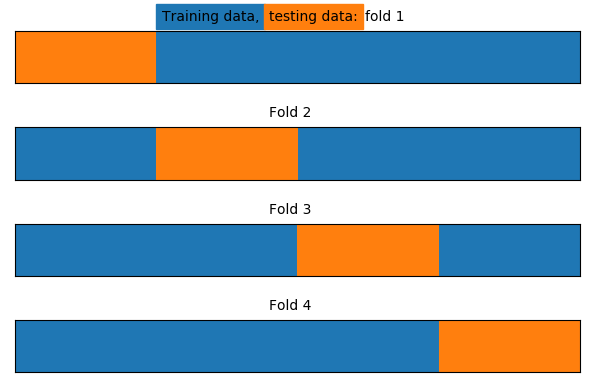

In [33]:
k_folds = KFold(n_splits=n_folds, shuffle=False)
plot_kfolds(k_folds)

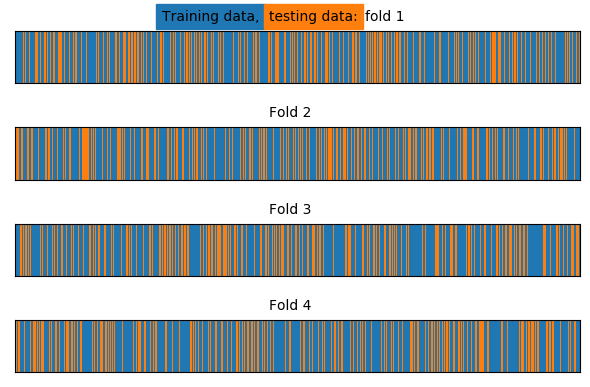

In [34]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True)
plot_kfolds(k_folds)

## Exercise 18: Reducing Overfitting on the Synthetic Data Classification Problem

<p>It's a good idea to try a few different number of flds and see how the mean and the variability of the k-folds testing score changes. Common numbers of folds can range anywhere from 4 to 10.</p>

<p>In the event of a very small dataset,k it may be necessary to use as much data as possible for training in the ross-validation folds.</p>

In [35]:
C_val_exponents = np.linspace(3,-3,13)
C_vals = np.float(10)**C_val_exponents

In [36]:
from sklearn.metrics import roc_curve

In [37]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    # a list of tuples of metrics (TPR, FPR, thersholds) for each C
    cv_test_roc = [[]]*len(C_vals)

    # each loops for training and testing each C
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [38]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores for each fold')

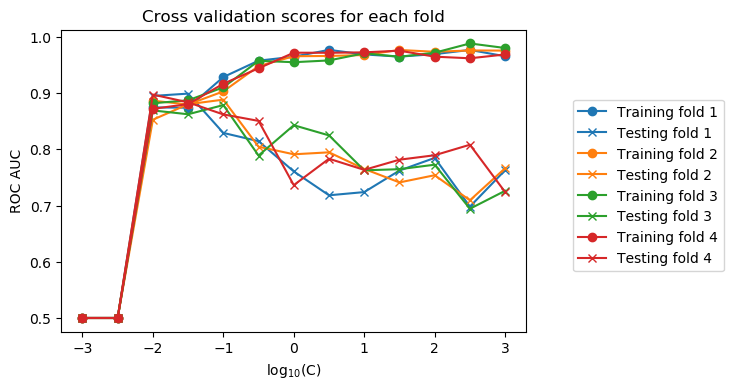

In [39]:
for this_fold in range(k_folds.n_splits):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color=cmap(this_fold), label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color=cmap(this_fold), label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

### Plot the mean of trainign and testing ROC AUC scroes for each C value

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

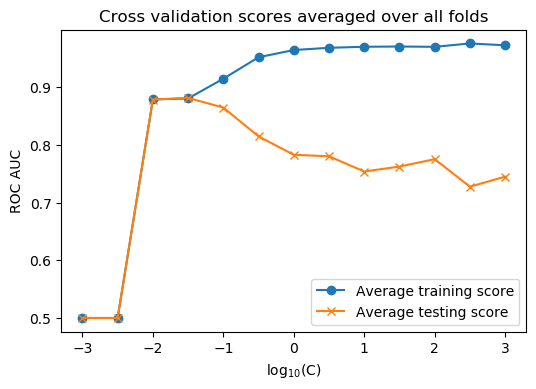

In [40]:
mpl.rcParams['figure.dpi'] = 100 #high res figures

plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

<p><strong>From this plot, it's clear that C=10-1.5 and 10-2 are the best values of C. There is little or no overfitting here, as the average traiing and testing scores are nearly the same.</strong></p>

### Access the true and false positive rates in order to plot the ROC curves for each fold

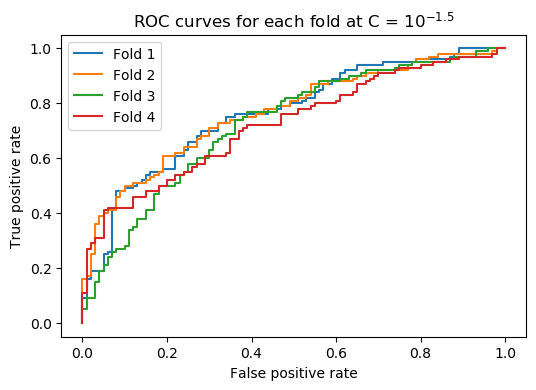

In [41]:
mpl.rcParams['figure.dpi'] = 100 #high res figures

chosen_C = -1.5
best_C_val_bool = C_val_exponents == chosen_C
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int))

for this_fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

### Train on all training data with the best C value

In [42]:
lr_syn.C = 10**(-1.5)

lr_syn.fit(X_syn_train, y_syn_train)

y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)

#### Training ROC AUC score

In [43]:
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.8802812499999999

#### Testing ROC AUC score

In [44]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8847884788478848

<p>Here, we can see that by using regularization, the model training and testing scores are similar, indicating that the overfitting problem has been solved.</p>

<p>The training score is lower, since we have introduced bias into the model at the expense of variance. Hoewver, this is okay, since the testing score, which is the most important, is higher.</p>

<p><strong>The out-of-sample testing score is what matters for predictive capability.</strong></p>

## Pipelines

<p>Previously, we used a logistic regressions model in the cross-validation loop. However, now that we're scaling data, what new considerations are there?</p> 

<p>The scaling is effectively "learned" from the from the minimum and maximum values of the training data. After this, a logistic regression model would be trained on data scaled by the extremes of the model training data.</p>

<p>We won't know the minimum and maximum values of the new, unseen data. So we need to use the minimum and maximum values of the training data in each cross-validation fold in order to scale to the testing data in that fold, before making predictions on the testing data.</p>

<p>Scikit-learn has streamlined this process for us in the form of a single tool:<strong>Pipeline</strong>. Our pipeline will consist of two steps: the <strong>scaler</strong> and the <strong>logistic regression model</strong>. These can both be fit on the training data, and then used to make predictions on the testing data. These steps occur simultaneously.</p>

#### Subset out of the features for the case study data

In [45]:
features = features_response[:-1]
print(len(features))
features

17


['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [46]:
X = df[features].values
X.shape

(26664, 17)

#### Make a train/test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


In [48]:
from sklearn.preprocessing import MinMaxScaler

min_max_sc = MinMaxScaler()

In [49]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

#### Put the Scaler and the Logistic Regression Model in one Pipeline

In [50]:
from sklearn.pipeline import Pipeline

scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('model',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=1000,
                      multi_class='auto', n_jobs=None, penalty='l1',
                      random_state=None, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fi

#### Make a new version of the cross_val_C_search function, called cross_val_C_search_pipe. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the C value using set_params(model_C = <value you want to test>) on the pipeline, replacing the model with the pipeline  for the fit and predict_proba methods, and accessing the C value using pipeline.get_params()['model__C'] for the printed status update.

In [51]:
C_val_exponents = np.linspace(2,-3,6)

C_vals = np.float(10)**C_val_exponents

def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [52]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


#### Polot the average training and testing ROC AUC across folds, for each C value

Text(0.5, 1.0, 'Cross validation on Case Study problem')

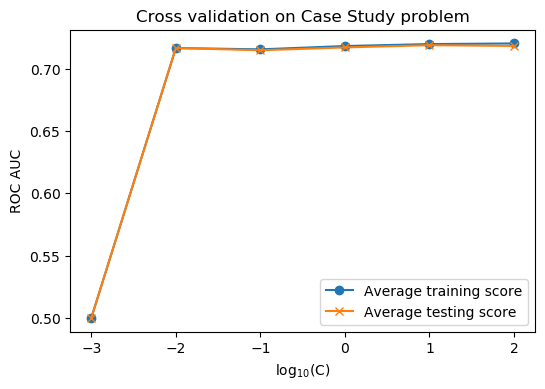

In [53]:
mpl.rcParams['figure.dpi'] = 100 #high res figures

plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')

<p><strong>Doesn't look like overfitting is happening. Our model may be underfitting. Let's try to engineer some new features to see if we can improve performance.</strong></p>

In [54]:
from sklearn.preprocessing import PolynomialFeatures

make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
X_interact, df['default payment next month'].values,test_size=0.2, random_state=24)

print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


#### Repeat the cross-validation procedure and observe the model performance now.

#### Note that this will take substantially more time, due to the larger number of features.

#### Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?

In [55]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100.0


C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10.0


C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ginger\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation on Case Study problem')

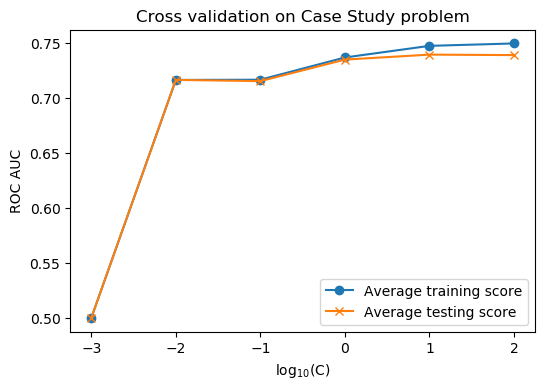

In [56]:
mpl.rcParams['figure.dpi'] = 100 #high res figures

plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation on Case Study problem')